## Application Computer Vision - HW1
#### Name: 涂佳伶
#### ID: 309514006  

### Explain each step of your detector in detail
First cell is going to import some module.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
from skimage.feature import peak_local_max

#### Step1.	Construct a Difference of Gaussian Scale Space
- Function **Gaussian** is used to generate a convolution kernel.
- Function **G_convolve** is used to generate Gaussian Pyramid. Output of this function is a 4-D array, and its shape is (num_octave, s+3, h, w) where (h, w) is the height and width of the input image.
- In **DoG**, the subtraction is going to be implemented between two adjacent gaussian images in the output of function **G_convolve**. This function will return a 4-D array array, and its shape is (num_octave, s, h, w). 

In [2]:
def Gaussian(sigma):
    n = np.ceil(sigma*6)    #window size 
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]
    y_filter = np.exp(-(y*y/(2.*sigma*sigma)))
    x_filter = np.exp(-(x*x/(2.*sigma*sigma)))
    filter_2d = (x_filter*y_filter) * (1/(2*np.pi*sigma**2))
    return filter_2d

def G_convolve(img, _params):
    k, sigma, s, Now_octave = _params
    dog_images = []
    for i in range(0, s+3):
        sigma_1 = sigma * np.power(k, i) * np.power(s, Now_octave)
        filter_gaussian = Gaussian(sigma_1)
        image = cv2.filter2D(img, -1, filter_gaussian)
        image = np.pad(image,((1,1),(1,1)),'reflect')
        image = np.square(image)
        dog_images.append(image)
    dog_image_np = np.array([i for i in dog_images])
    return dog_image_np

def DoG(img, _params):
    k, sigma, s, num_octave = _params
    _DoG_images = []
    for i in range(0, num_octave):
        _params[-1]=i
        _g_image_np = G_convolve(img, _params)
        dog_images = [ (_g_image_np[j+1] - _g_image_np[j] ) for j in range(s+2) ]
        _DoG_images.append(dog_images)
    _DoG_images = np.array([i for i in _DoG_images])
    return _DoG_images

#### Step2.	Non-Maximum Suppression (NMS) in Scale Space
- Function **dog_find_extrema** consists of two steps. Fisrt, a *Scipy* function *peak_local_maxis* is applied to extract the locations of the maximas on one DoG image. Second, keep the items which response is greater than its 26 scale-space neighbors.

In [3]:
def dog_find_extrema(dog_image_np, current_sigma, threshold_rel):
    _co_ordinates = []
    local_maxima_in_2D = peak_local_max(dog_image_np[1], threshold_rel=threshold_rel)
    # return a ndarray [[355, 355], [282, 273]] for example
    
    for coords in local_maxima_in_2D:
        row, col = coords
        cubic_img = dog_image_np[:,row-1:row+2,col-1:col+2]
        if np.sum(cubic_img <= dog_image_np[1, row, col])==27:
            _co_ordinates.append((row, col, np.max(cubic_img), current_sigma))
                                
    return _co_ordinates

#### Step3.	Non-Maximum Suppression (NMS) on Blob Region and Response of the Features 
- Function **filter_value** will throw the items away which response is *x%* lower than the max response value. 
- Function **redundancy** will throw the items away which overlay with another larger response blob.

In [4]:
def filter_value(features, rel):
    max_response = np.max(np.array(features)[:, -2])
    mask = np.array(np.array(features)[:, -2] >= max_response*rel)
    idx = np.array(np.where(np.array(mask)==1))[0]
    return [features[i] for i in idx]   

def blob_overlap(blob1, blob2):
    n_dim = len(blob1) - 2
    root_ndim = np.sqrt(n_dim)
    #print(n_dim)
    
    # radius of two blobs
    r1 = blob1[-1] * root_ndim
    r2 = blob2[-1] * root_ndim
    
    d = np.sqrt(np.sum((blob1[:-2] - blob2[:-2])**2))
    
    #no overlap between two blobs
    if d > r1 + r2:
        return 0
    # one blob is inside the other, the smaller blob must die
    elif d <= abs(r1 - r2):
        return 1
    else:
        #computing the area of overlap between blobs
        ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
        ratio1 = np.clip(ratio1, -1, 1)
        acos1 = np.arccos(ratio1)

        ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
        ratio2 = np.clip(ratio2, -1, 1)
        acos2 = np.arccos(ratio2)

        a = -d + r2 + r1
        b = d - r2 + r1
        c = d + r2 - r1
        d = d + r2 + r1

        area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -0.5 * np.sqrt(abs(a * b * c * d)))
        return area/(np.pi * (min(r1, r2) ** 2))
    
def redundancy(blobs_tuple_list, overlap):
    blobs_array = np.array(blobs_tuple_list)
    sigma = blobs_array[:, -1].max()
    distance = 2 * sigma * np.sqrt(blobs_array.shape[1] - 2)
    tree = spatial.cKDTree(blobs_array[:, :-2])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_tuple_list
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if blob_overlap(blob1, blob2) > overlap:
                if blob1[-2] > blob2[-2]:
                    blob2[-1] = 0
                else:
                    blob1[-1] = 0
        remain = np.array([b for b in blobs_array if b[-1] > 0])        
        return list(tuple(map(tuple, remain)))

#### Step4.	Define a Blob Detector
- Retun the image with detected blobs and give the number of blobs detected.

In [5]:
class blob_detector():
    def __init__(self, params):
        # initialize your detector
        self.s = params['s']
        self.sigma = params['sigma']
        self.num_octave = params['num_octave']
        self.threshold_rel = params['threshold_rel']
        
        self.overlap_ratio = 0.01
        self.K = np.power(2, 1/self.s)
        
    def detect(self, img): 
        
        # ========= TODO: implement your blob detecting function here =========== #
        p = [self.K, self.sigma, self.s ,self.num_octave]
        dog_image_np = DoG(img/255.0, _params=p)
        features = []
        for n in range(0, self.num_octave):
            for m in range(1, self.s+1):   
                current_sigma = np.power(2,n)*np.power(self.K,m)*self.sigma
                feature_on_a_scale = dog_find_extrema(dog_image_np[n][m-1:m+2], 
                                              current_sigma, self.threshold_rel)
                features += feature_on_a_scale            
        features = filter_value(features, self.threshold_rel)
        
        co_ordinates = redundancy(features, self.overlap_ratio)     
        # =================== Return ======================= #
        blob_number = len(co_ordinates)
        blob_plot = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
        fig, ax = plt.subplots()
        nh,nw = img.shape
        
        ax.imshow(img, interpolation='nearest', cmap="gray")
        for blob in co_ordinates:
            y,x,reponse,r = blob
            c = plt.Circle((x, y), r*1.414, color='red', linewidth=1.5, fill=False)
            ax.add_patch(c)
        ax.plot()  
        plt.show()
        return blob_number, blob_plot

### Results of Question 1 and 2
#### Parameters 
&emsp;Parameters are setting as an directory.
> **img** : ndarray
&emsp;Input image.  
>
> **s** : int  
&emsp;Number of scale levels in each ovtave.  
>
> **num_octave** : int  
&emsp;Number of octaves.
>
> **sigma** : float  
&emsp;Inintial kernel size.
>
> **threshold_rel** : float  
&emsp;minimumn response (*threshold_rel*): 0.53, calculated as max_response *  *threshold_rel*.

#### Dots Image

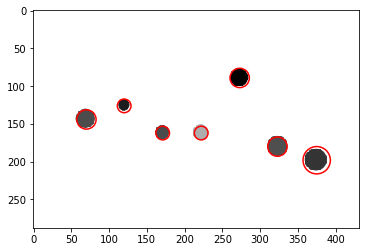

Number of blobs: 7


In [6]:
img = cv2.imread(r'D:\Computer vision course\HW1\img\dots.jpeg', 0)
params = {
    's': 2, 
    'sigma' : 1.6,
    'num_octave': 4,
    'threshold_rel':0.53,
    }
detector = blob_detector(params)
blob_number, blob_plot = detector.detect(img)

# Display your results
print('Number of blobs:', blob_number)
cv2.imshow('Figure', blob_plot)

### Butterfly Image

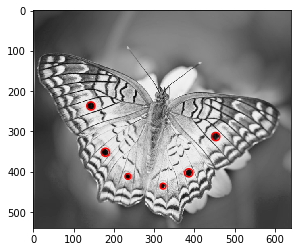

Number of blobs: 6


In [7]:
img = cv2.imread(r'D:\Computer vision course\HW1\img\butterfly.jpeg', 0)
params = {
    's': 2, 
    'sigma' : 1.8,
    'num_octave': 4,
    'threshold_rel':0.9,
    }
detector = blob_detector(params)
blob_number, blob_plot = detector.detect(img)

# Display your results
print('Number of blobs:', blob_number)
cv2.imshow('Figure', blob_plot)

### Dice Image

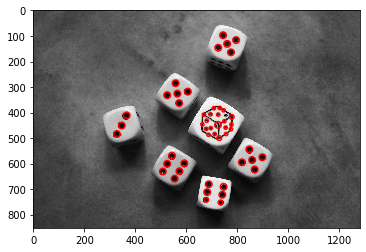

Number of blobs: 50


In [ ]:
img = cv2.imread(r'D:\Computer vision course\HW1\img\dice.jpeg', 0)
params = {
    's': 2, 
    'sigma' : 3.2,
    'num_octave': 3,
    'threshold_rel':0.4,
    }
detector = blob_detector(params)
blob_number, blob_plot = detector.detect(img)

# Display your results
print('Number of blobs:', blob_number)
cv2.imshow('Figure', blob_plot)

### Discussion
1. The intensity of the dots in the image is very inconsistent. To find all the dots, the minimum response value allowed to be recognized as a blob is set lower. In my experiment, the smallest response value are set to be 0.53 times the maximum value.  
2. Invert the color of the Dice image and set a larger sigma(ex: 35 pixels), then we can detect the dice itselt with white shell without modifying the funciton defined above.
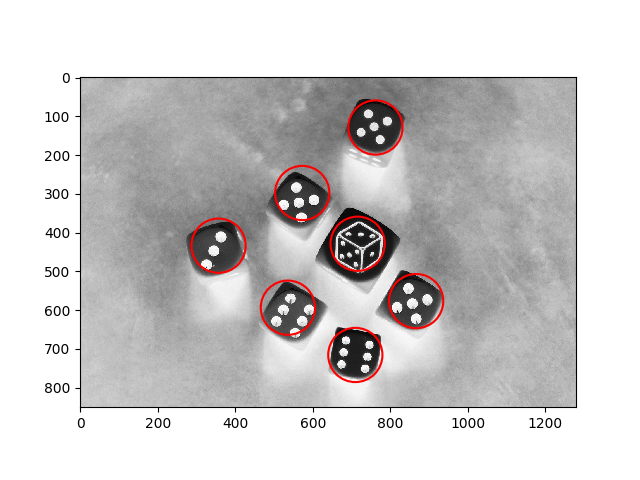

### Reference 
1. Refer to tips written in the [Assignment](https://www.di.ens.fr/willow/teaching/recvis10/assignment1) of UNC .
2. Refer to [this github](https://github.com/nish97v/blob-detector) for part of the code